# Bibliotecas

In [ ]:
# Pronóstico de Series de Tiempo

# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Construcción de la serie de tiempo**

In [ ]:
# Tomar datos del url en formato "raw"
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_mlo_DailyData.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['site_code','year','month','day','hour','minute','second','time_decimal','value','value_std_dev','nvalue','latitude','longitude','altitude','elevation','intake_height','qcflag']
df_H = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=1, engine='python') 

# Se hace copia del DF y agregamos una columna para la fecha
df_H0 = df_H.copy()
df_H1 = pd.DataFrame(df_H0,columns=['year','month','day'])
df_H1['Date'] = pd.to_datetime(df_H1) 
df_H1['Value'] = df_H['value'] 
df_H1.drop(['year','month','day'], axis=1, inplace=True)
# print(df_hawaii1.head())

# Eliminamos valores nulos (-999.99)
str_Nulo = -999.99 
df_H1 = df_H1.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Usamos 'Date' como índice
df_H1 = df_H1.set_index('Date')


# Creamos una serie de tiempo de 1980-2019
start, end = '1980-01', '2019-12'
df_H2 = df_H1.loc[start:end].copy()

# Agregamos los datos con los que vamos a trabajar
ts_test = df_H2['Value']
ts_test = ts_test.astype(float)
ts_test.ffill(axis = 0, inplace=True)

print(ts_test.head())
print(ts_test.tail())

Date
1980-01-01    337.85
1980-01-02    337.32
1980-01-03    337.75
1980-01-04    337.70
1980-01-05    337.65
Name: Value, dtype: float64
Date
2019-12-26    412.59
2019-12-27    412.85
2019-12-28    412.34
2019-12-29    412.98
2019-12-30    413.30
Name: Value, dtype: float64


# Análisis de la serie de tiempo

In [ ]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries' 
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar', size=18)
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

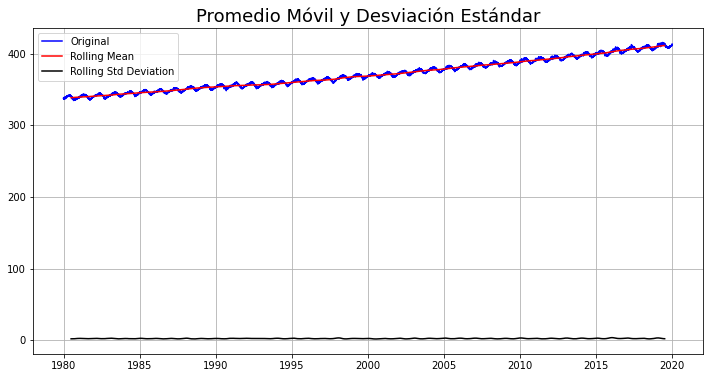

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -1.023213
p-value                            0.744704
#Lags Used                        42.000000
Number of Observations Used    14566.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
# Realizamos la Prueba de Estacionaridad
test_stationarity(ts_test)

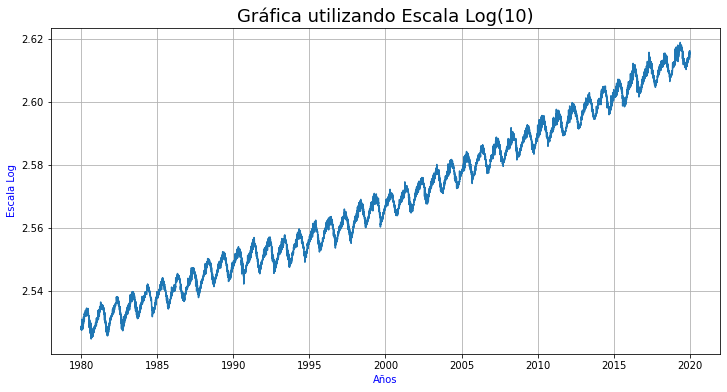

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

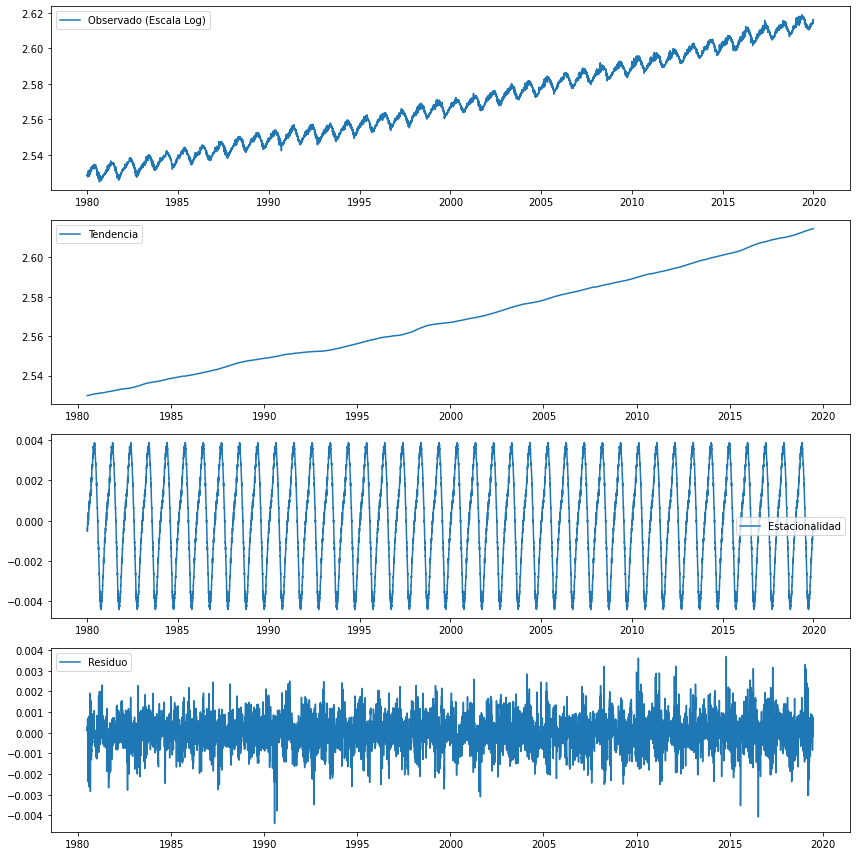

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

Podemos notar como la tendencia va de subida, es decir cada vez hay más emisiones. La estacionalidad tiene un ciclo definido y el residuo se encuentra dentro de un rango y tiene sus extremos a lo largo de los años.

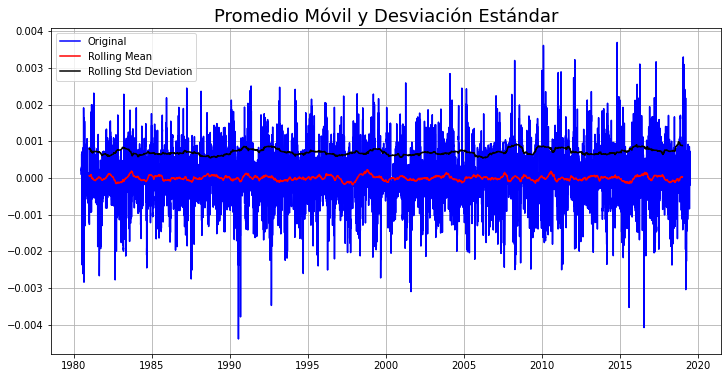

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -19.161429
p-value                            0.000000
#Lags Used                        21.000000
Number of Observations Used    14223.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria
ts_test_log_decompose = residue
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

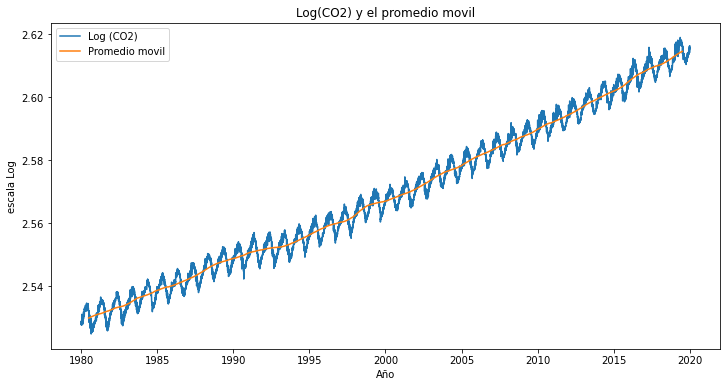

In [ ]:
# Se calcula el promedio movil
moving_avg = ts_test_log.rolling(365, center=True).mean()

# Gráfica promedio movil con Log sobrepuesta
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test_log, label='Log (CO2)');
plt.plot(moving_avg, label='Promedio movil');
plt.xlabel('Año')
plt.ylabel('escala Log')
plt.title('Log(CO2) y el promedio movil')
plt.legend(loc='best');

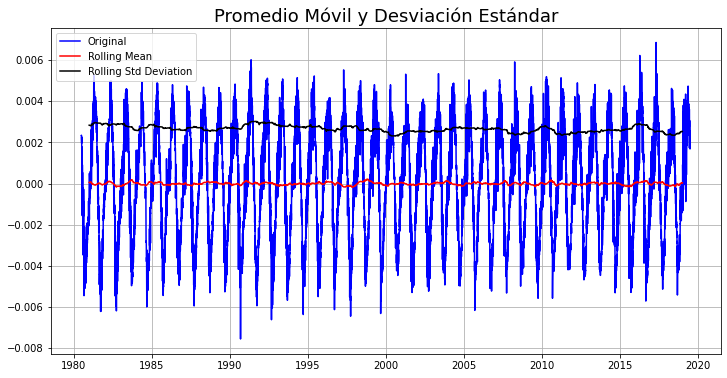

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.400738e+01
p-value                        3.766921e-26
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Nuevo DF, diferencia entre serie log y promedio móvil
ts_test_log_moving_ave_diff = ts_test_log - moving_avg

ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head() 

# Prueba de estacionaridad
test_stationarity(ts_test_log_moving_ave_diff) 

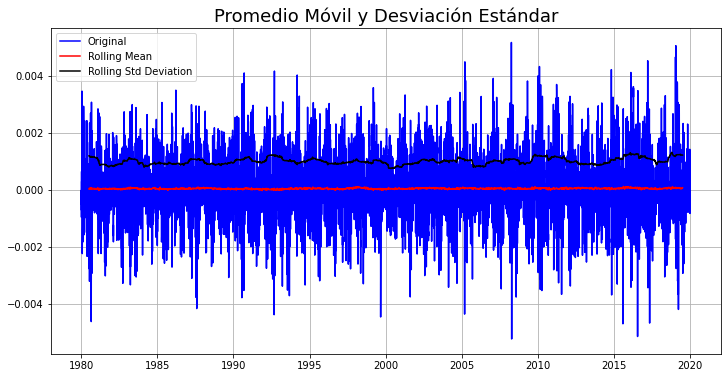

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.002419e+01
p-value                        1.648540e-17
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [ ]:
# Serie estacionaria usando función de diferenciación shift() con periodo de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff.dropna(inplace=True) 

# Prueba estacionaria
test_stationarity(ts_test_log_diff)

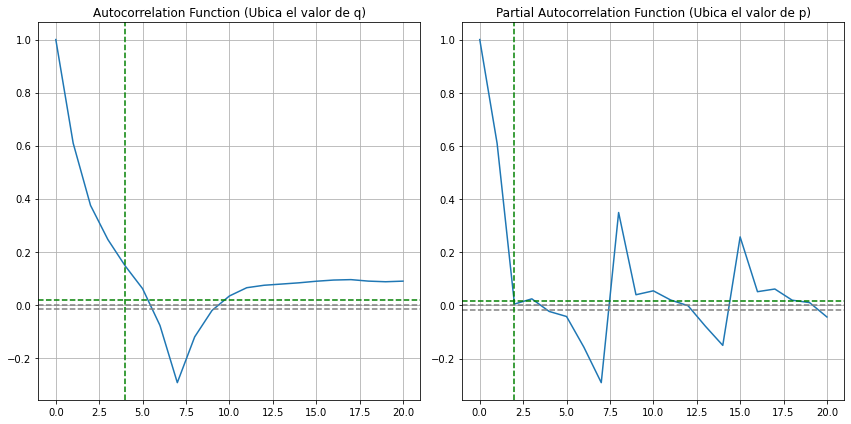

In [ ]:
# Aplicamos ARIMA
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14608
Model:                 ARIMA(2, 1, 0)   Log Likelihood               87403.569
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -174799.137
Time:                        06:32:50   BIC                        -174768.780
Sample:                    01-02-1980   HQIC                       -174789.052
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.989e-06   3.53e-06      1.699      0.089   -9.22e-07    1.29e-05
ar.L1.D.Value    -0.2438      0.008    -29.993      0.000      -0.260      -0.228
ar.L2.D.Value    -0.1875      0.008    -

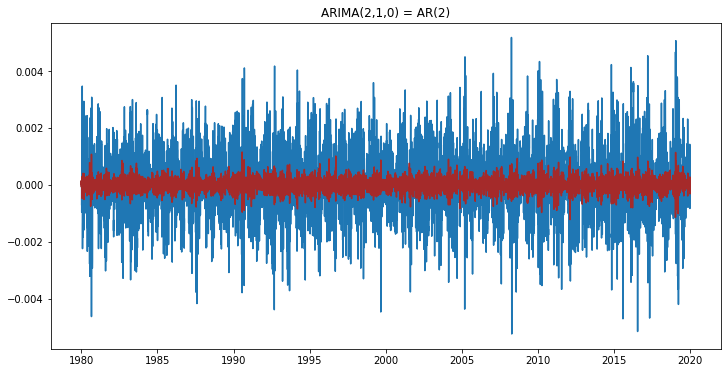

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14608
Model:                 ARIMA(0, 1, 5)   Log Likelihood               87732.723
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -175451.447
Time:                        06:32:55   BIC                        -175398.321
Sample:                    01-02-1980   HQIC                       -175433.798
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.973e-06   2.07e-06      2.891      0.004    1.92e-06       1e-05
ma.L1.D.Value    -0.3033      0.008    -36.629      0.000      -0.320      -0.287
ma.L2.D.Value    -0.1837      0.009    -

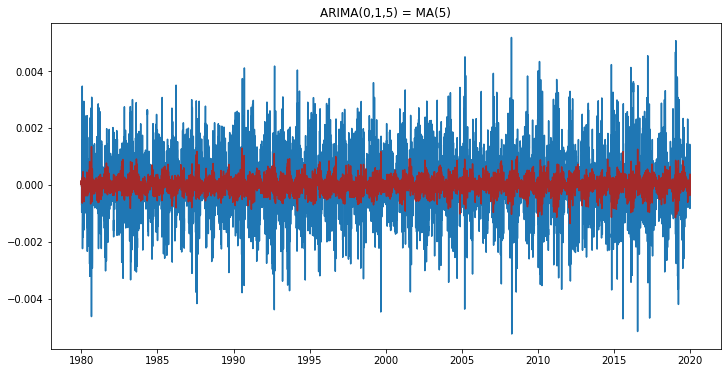

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model = ARIMA(ts_test_log, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                14608
Model:                 ARIMA(2, 1, 5)   Log Likelihood               87739.752
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -175461.504
Time:                        06:33:11   BIC                        -175393.200
Sample:                    01-02-1980   HQIC                       -175438.812
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.977e-06   2.17e-06      2.750      0.006    1.72e-06    1.02e-05
ar.L1.D.Value     0.4265      0.250      1.703      0.089      -0.064       0.917
ar.L2.D.Value     0.2378      0.236     

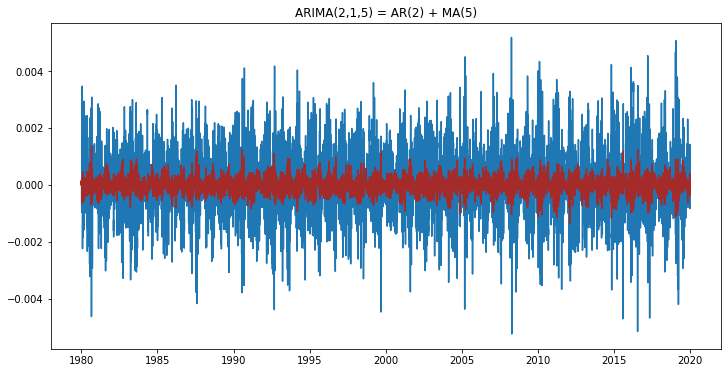

In [ ]:
# Modelo ARIMA(p,d,q): (p,d,q) = (2,1,5) 
model = ARIMA(ts_test_log, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA.summary());

Comparamos los AIC de los modelos

AR(p) = -174799.137

MA(q) = -175451.447

ARIMA(p,d,q) = -175461.504

ARIMA tiene el menor valor de AIC

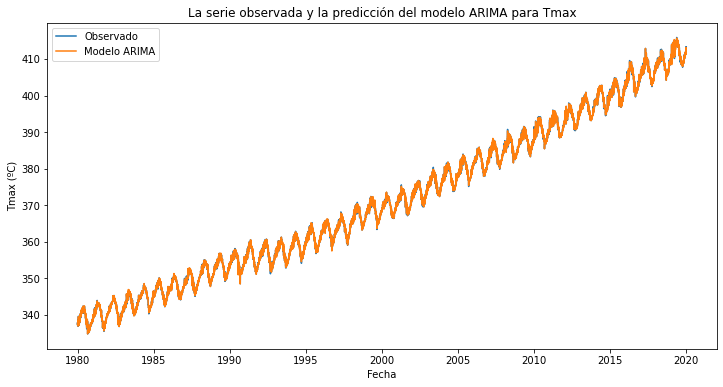

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)

# Regresamos a la escala de Temperatura original 
predictions_ARIMA= 10**(predictions_ARIMA_log)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.1892963608885916


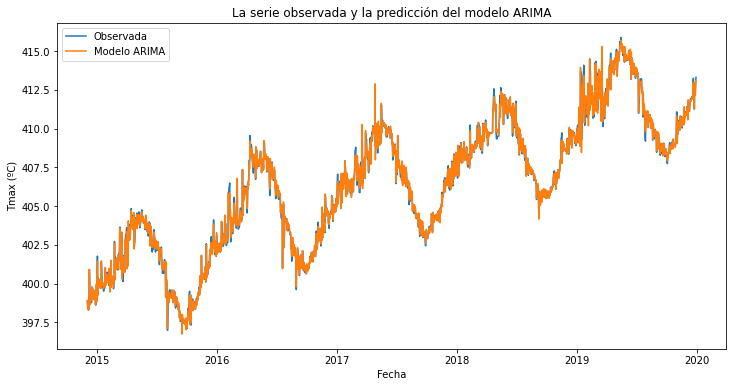

In [ ]:
# Graficamos sólo los útimos datos de las series 
start, end = '2014-12', '2019-12'

ts_test_last = ts_test.loc[start:end]
predictions_ARIMA_last = predictions_ARIMA.loc[start:end]
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');